# Apply PCM to argo reference data base

First try

In [1]:
import xarray as xr
import numpy as np
import numpy.ma as ma
import pandas as pd

import pyxpcm
from pyxpcm.models import pcm

import Plotter
from Plotter import Plotter

from BIC_calculation import *

from classif_functions import *
 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import sys
np.set_printoptions(threshold=sys.maxsize)

import configparser

### __User inputs__

Read configuration file

In [2]:
config_filename = '/home1/homedir5/perso/agarciaj/EARISE/DMQC-PCM/OWC-pcm/matlabow/ow_config.txt'

with open(config_filename) as f:
    file_content = '[configuration]\n' + f.read()

config_parser = configparser.RawConfigParser(comment_prefixes='%')
config_parser.read_string(file_content)
config = config_parser['configuration']

In [ ]:
for key in config_parser['configuration']:  
    print(key)

In [ ]:
config['config_wmo_boxes']

Reference data selection and paths

In [3]:
# depth for interpolation
max_depth = 1000
# chose season ('DJF', 'MAM', 'JJA', 'SON' or 'all') for training dataset
season = ['all']
# paths
WMOboxes_latlon='WMO_boxes_latlon.txt'
#wmo_boxes= config['config_directory'] + config['config_wmo_boxes']
wmo_boxes='wmo_boxes_argo.mat'
#ref_path = '/home1/homedir5/perso/agarciaj/EARISE/OW/matlabow/data/climatology/'
ref_path = config['historical_directory']

Float you want to correct

In [4]:
# agulhas current
float_mat_path = config['float_source_directory'] + '/test3/3901915.mat'
float_WMO = 3901915
# southern ocean
#float_mat_path = config['float_source_directory'] + '/test2/3901928.mat'
#float_WMO = 3901928
# north atlantic 
#float_mat_path = '/home1/homedir5/perso/agarciaj/EARISE/DMQC-PCM/OWC-pcm/matlabow/data/float_source/test1/4900136.mat'
#float_WMO = 4900136

Model parameters

In [5]:
K=5 # number of classes

## 1. Load argo reference database

__Load argo reference database__

In [6]:
ds = get_refdata(float_mat_path = float_mat_path, 
                 WMOboxes_latlon = WMOboxes_latlon, 
                 wmo_boxes = wmo_boxes, 
                 ref_path = ref_path,
                 config = config,
                 map_pv_use = 0)

/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3100.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3200.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3300.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3400.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3500.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3101.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3201.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3301.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3401.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3501.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3302.mat
/home5/pharos/argo/DMARGO/OW/VER

In [7]:
print(ds)

<xarray.Dataset>
Dimensions:     (n_pres: 1032, n_profiles: 38018)
Coordinates:
    long        (n_profiles) float64 8.207 8.405 8.415 ... 351.5 351.7 351.7
    lat         (n_profiles) float64 -19.96 -19.76 -19.75 ... -43.63 -43.45
    dates       (n_profiles) datetime64[ns] 2007-01-19T10:09:04 ... 2018-05-2...
  * n_profiles  (n_profiles) int64 0 1 2 3 4 5 ... 38013 38014 38015 38016 38017
  * n_pres      (n_pres) int64 0 1 2 3 4 5 6 ... 1026 1027 1028 1029 1030 1031
Data variables:
    pres        (n_pres, n_profiles) float64 10.0 10.0 10.0 10.0 ... nan nan nan
    temp        (n_pres, n_profiles) float64 21.88 22.46 22.31 ... nan nan nan
    sal         (n_pres, n_profiles) float64 35.62 35.67 35.64 ... nan nan nan
    source      (n_profiles) <U46 '1900165_145.BRECKOWENS' ... '5903260_301.S...
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue S...
    __version__:  1.0
    __globals__:  1.0


## 2. Create training dataset

Use a regular sampling

In [8]:
%%time
corr_dist = 50 # in km
ds_t = get_regulargrid_dataset(ds, corr_dist, season=season)

no more points to delate
3668
CPU times: user 1min 45s, sys: 8.04 s, total: 1min 53s
Wall time: 1min 56s


In [9]:
print(ds_t)

<xarray.Dataset>
Dimensions:     (n_pres: 1032, n_profiles: 3669)
Coordinates:
    long        (n_profiles) float64 8.751 7.92 2.207 ... 353.1 354.0 350.5
    lat         (n_profiles) float64 -19.57 -18.8 -19.73 ... -44.99 -43.59
    dates       (n_profiles) datetime64[ns] 2008-11-26T11:34:57 ... 2018-04-1...
  * n_profiles  (n_profiles) int64 25 31 49 61 64 ... 37971 37973 38003 38013
  * n_pres      (n_pres) int64 0 1 2 3 4 5 6 ... 1026 1027 1028 1029 1030 1031
Data variables:
    pres        (n_pres, n_profiles) float64 5.0 5.0 5.0 5.0 ... nan nan nan nan
    temp        (n_pres, n_profiles) float64 19.17 23.02 21.53 ... nan nan nan
    sal         (n_pres, n_profiles) float64 35.64 35.84 35.88 ... nan nan nan
    source      (n_profiles) object '1900740_074.BRECKOWENS' ... '5903260_297...
    mask_s      (n_profiles) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue S...
    __version__:  1.0


plot dataset

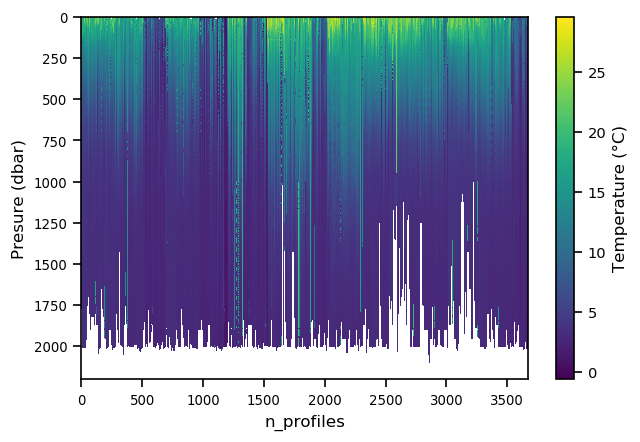

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), dpi=120, facecolor='w', edgecolor='k')
sc = ax.pcolor(np.tile(np.arange(len(ds_t['n_profiles'])), (len(ds_t['n_pres']),1)), ds_t['pres'], ds_t['temp'], cmap='viridis')
ax.invert_yaxis()
cbar = plt.colorbar(sc)
cbar.set_label('Temperature (°C)', fontsize=10)
ax.tick_params(axis="x", labelsize=8)
ax.tick_params(axis="y", labelsize=8)
ax.set_ylabel('Presure (dbar)', fontsize=10);
ax.set_xlabel('n_profiles', fontsize=10);

__Interpolate to standard levels__

In [11]:
std_lev = np.arange(0,max_depth)
ds_t = interpolate_standard_levels(ds_t, std_lev)

/home1/homedir5/perso/agarciaj/EARISE/DMQC-PCM/PCM-design/classif_functions.py:128: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  remapped = xr.apply_ufunc(_regular_interp, z, data, z_regridded, **kwargs)


In [12]:
# some format
#pres should be negative for the PCM
ds_t['PRES_INTERPOLATED'] = -np.abs(ds_t['PRES_INTERPOLATED'].values)
#axis attributtes for plotter class
ds_t.PRES_INTERPOLATED.attrs['axis'] = 'Z'
ds_t.lat.attrs['axis'] = 'Y'
ds_t.long.attrs['axis'] = 'X'
ds_t.dates.attrs['axis'] = 'T'

In [13]:
print(ds_t)

<xarray.Dataset>
Dimensions:            (PRES_INTERPOLATED: 1000, n_profiles: 3550)
Coordinates:
    long               (n_profiles) float64 2.207 5.717 0.603 ... 354.0 350.5
    lat                (n_profiles) float64 -19.73 -18.18 ... -44.99 -43.59
    dates              (n_profiles) datetime64[ns] 2008-01-02T13:29:41 ... 20...
  * n_profiles         (n_profiles) int64 49 61 64 67 ... 37973 38003 38013
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 -1 -2 -3 ... -997 -998 -999
Data variables:
    mask_s             (n_profiles) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    pres               (n_profiles, PRES_INTERPOLATED) float64 5.0 5.0 ... 999.0
    sal                (n_profiles, PRES_INTERPOLATED) float64 35.88 ... 34.29
    source             (n_profiles) object '1900741_041.BRECKOWENS' ... '5903...
    temp               (n_profiles, PRES_INTERPOLATED) float64 21.53 ... 3.149
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue S...
    

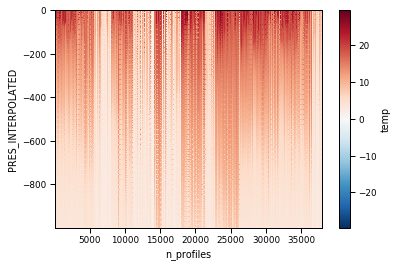

In [14]:
ds_t['temp'].plot(x='n_profiles');

Spatial distribution of training dataset

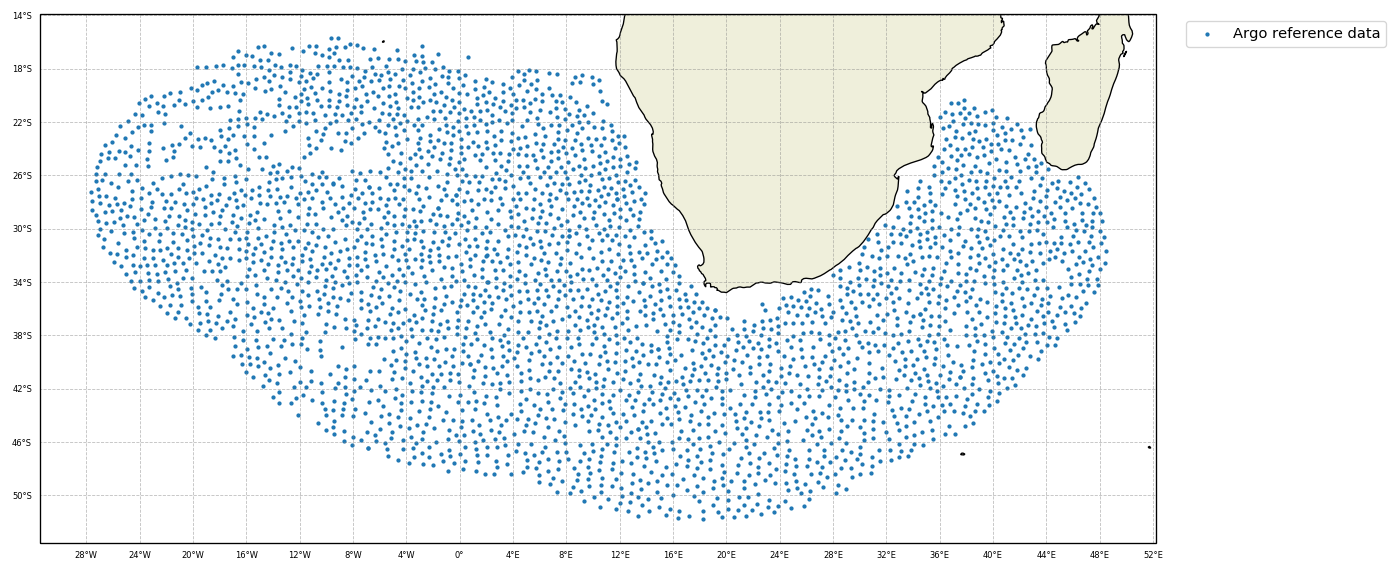

In [15]:
#ds_t = ds
proj=ccrs.PlateCarree()
subplot_kw = {'projection': proj}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(
            12, 12), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

p1 = ax.scatter(ds_t['long'], ds_t['lat'], s=3, transform=proj, label='Argo reference data')

land_feature = cfeature.NaturalEarthFeature(
            category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
ax.add_feature(land_feature, edgecolor='black')

defaults = {'linewidth': .5, 'color': 'gray', 'alpha': 0.5, 'linestyle': '--'}
gl = ax.gridlines(crs=ax.projection,draw_labels=True, **defaults)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180+1, 4))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90+1, 4))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'fontsize': 5}
gl.ylabel_style = {'fontsize': 5}
gl.xlabels_top = False
gl.ylabels_right = False

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

## 3. Create prediction dataset

Add float data to initial dataset

In [16]:
ds_p = add_floatdata(float_WMO, float_mat_path, ds)

In [17]:
print(ds_p)

<xarray.Dataset>
Dimensions:     (n_pres: 1032, n_profiles: 38223)
Coordinates:
  * n_profiles  (n_profiles) int64 0 1 2 3 4 5 ... 38218 38219 38220 38221 38222
    long        (n_profiles) float64 8.207 8.405 8.415 ... 350.6 350.5 350.3
    lat         (n_profiles) float64 -19.96 -19.76 -19.75 ... -27.8 -27.73
    dates       (n_profiles) datetime64[ns] 2007-01-19T10:09:04 ... 2021-01-01
  * n_pres      (n_pres) int64 0 1 2 3 4 5 6 ... 1026 1027 1028 1029 1030 1031
Data variables:
    pres        (n_pres, n_profiles) float64 10.0 10.0 10.0 10.0 ... nan nan nan
    temp        (n_pres, n_profiles) float64 21.88 22.46 22.31 ... nan nan nan
    sal         (n_pres, n_profiles) float64 35.62 35.67 35.64 ... nan nan nan
    source      (n_profiles) object '1900165_145.BRECKOWENS' ... 'selected_fl...
    mask_s      (n_profiles) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue S...
    __version__:  1

plot dataset

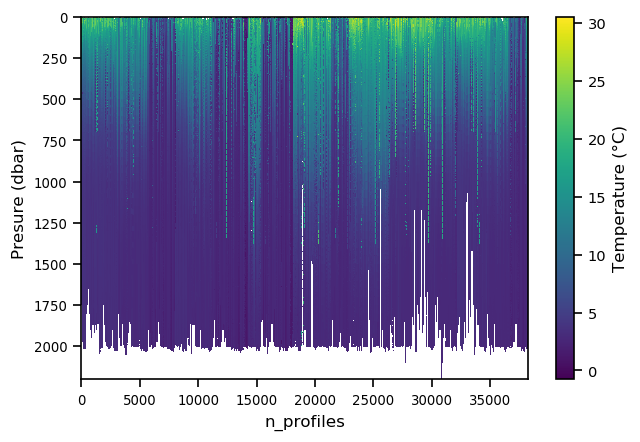

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), dpi=120, facecolor='w', edgecolor='k')
sc = ax.pcolor(np.tile(ds_p['n_profiles'], (len(ds_p['n_pres']),1)), ds_p['pres'], ds_p['temp'], cmap='viridis')
ax.invert_yaxis()
cbar = plt.colorbar(sc)
cbar.set_label('Temperature (°C)', fontsize=10)
ax.tick_params(axis="x", labelsize=8)
ax.tick_params(axis="y", labelsize=8)
ax.set_ylabel('Presure (dbar)', fontsize=10);
ax.set_xlabel('n_profiles', fontsize=10);

__Interpolate to standard levels__

In [19]:
std_lev = np.arange(0,max_depth)
ds_p = interpolate_standard_levels(ds_p, std_lev)

/home1/homedir5/perso/agarciaj/EARISE/DMQC-PCM/PCM-design/classif_functions.py:128: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  remapped = xr.apply_ufunc(_regular_interp, z, data, z_regridded, **kwargs)


In [20]:
# some format
#pres should be negative for the PCM
ds_p['PRES_INTERPOLATED'] = -np.abs(ds_p['PRES_INTERPOLATED'].values)
#axis attributtes for plotter class
ds_p.PRES_INTERPOLATED.attrs['axis'] = 'Z'
ds_p.lat.attrs['axis'] = 'Y'
ds_p.long.attrs['axis'] = 'X'
ds_p.dates.attrs['axis'] = 'T'

In [21]:
print(ds_p)

<xarray.Dataset>
Dimensions:            (PRES_INTERPOLATED: 1000, n_profiles: 36882)
Coordinates:
  * n_profiles         (n_profiles) int64 0 1 2 3 4 ... 38219 38220 38221 38222
    long               (n_profiles) float64 8.207 8.405 8.415 ... 350.5 350.3
    lat                (n_profiles) float64 -19.96 -19.76 ... -27.8 -27.73
    dates              (n_profiles) datetime64[ns] 2007-01-19T10:09:04 ... 20...
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 -1 -2 -3 ... -997 -998 -999
Data variables:
    mask_s             (n_profiles) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    pres               (n_profiles, PRES_INTERPOLATED) float64 10.0 ... 999.0
    sal                (n_profiles, PRES_INTERPOLATED) float64 35.62 ... 34.43
    source             (n_profiles) object '1900165_145.BRECKOWENS' ... 'sele...
    temp               (n_profiles, PRES_INTERPOLATED) float64 21.88 ... 3.857
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue S...
   

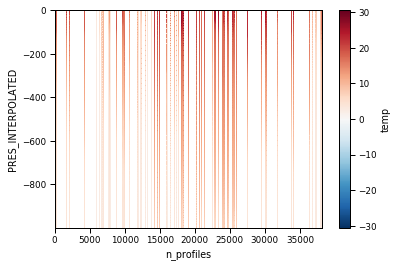

In [22]:
ds_p['temp'].plot(x='n_profiles');

__Plot float trajectory and ref profiles__

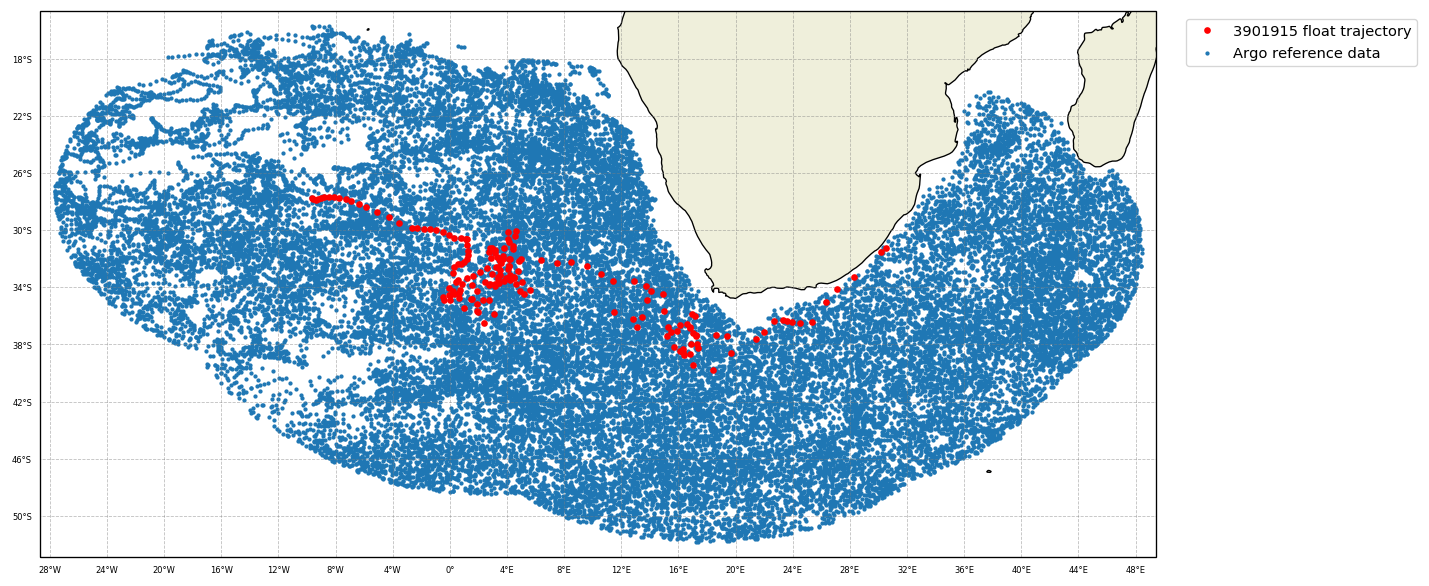

In [23]:
selected_float_index = [i for i, isource in enumerate(ds_p['source'].values) if isource == 'selected_float']

proj=ccrs.PlateCarree()
subplot_kw = {'projection': proj}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(
            12, 12), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

p1 = ax.scatter(ds_p['long'], ds_p['lat'], s=3, transform=proj, label='Argo reference data')
p2 = ax.plot(ds_p['long'].isel(n_profiles = selected_float_index), ds_p['lat'].isel(n_profiles = selected_float_index), 
                 'ro', transform=proj, markersize = 3, label = str(float_WMO) + ' float trajectory')

land_feature = cfeature.NaturalEarthFeature(
            category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
ax.add_feature(land_feature, edgecolor='black')

defaults = {'linewidth': .5, 'color': 'gray', 'alpha': 0.5, 'linestyle': '--'}
gl = ax.gridlines(crs=ax.projection,draw_labels=True, **defaults)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180+1, 4))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90+1, 4))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'fontsize': 5}
gl.ylabel_style = {'fontsize': 5}
gl.xlabels_top = False
gl.ylabels_right = False
lon_180 = np.mod((ds_p['long']+180),360)-180
ax.set_xlim([lon_180.min()-1, lon_180.max()+1])
ax.set_ylim([ds_p['lat'].min()-1, ds_p['lat'].max()+1])


plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

## 4. Apply PCM

Create model

In [24]:
z_dim = 'PRES_INTERPOLATED'
var_name_mdl = ['temp', 'sal']

# pcm feature
z = ds_t[z_dim]
pcm_features = {var_name_mdl[0]: z, var_name_mdl[1]: z}

m = pcm(K=K, features=pcm_features)
m

<pcm 'gmm' (K: 5, F: 2)>
Number of class: 5
Number of feature: 2
Feature names: odict_keys(['temp', 'sal'])
Fitted: False
Feature: 'temp'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Feature: 'sal'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>

Fit model

In [25]:
var_name_ds = ['temp', 'sal']
# Variable to be fitted {variable name in model: variable name in dataset}
features_in_ds = {var_name_mdl[0] : var_name_ds[0], var_name_mdl[1] : var_name_ds[1]}

m.fit(ds_t, features=features_in_ds, dim=z_dim)
m

<pcm 'gmm' (K: 5, F: 2)>
Number of class: 5
Number of feature: 2
Feature names: odict_keys(['temp', 'sal'])
Fitted: True
Feature: 'temp'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Feature: 'sal'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 36.559153

Predict labels

In [26]:
#ds_p = ds_t
m.predict(ds_p, features=features_in_ds, inplace = True)
print(ds_p)

<xarray.Dataset>
Dimensions:            (PRES_INTERPOLATED: 1000, n_profiles: 36882)
Coordinates:
  * n_profiles         (n_profiles) int64 0 1 2 3 4 ... 38219 38220 38221 38222
    long               (n_profiles) float64 8.207 8.405 8.415 ... 350.5 350.3
    lat                (n_profiles) float64 -19.96 -19.76 ... -27.8 -27.73
    dates              (n_profiles) datetime64[ns] 2007-01-19T10:09:04 ... 20...
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 -1 -2 -3 ... -997 -998 -999
Data variables:
    mask_s             (n_profiles) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    pres               (n_profiles, PRES_INTERPOLATED) float64 10.0 ... 999.0
    sal                (n_profiles, PRES_INTERPOLATED) float64 35.62 ... 34.43
    source             (n_profiles) object '1900165_145.BRECKOWENS' ... 'sele...
    temp               (n_profiles, PRES_INTERPOLATED) float64 21.88 ... 3.857
    PCM_LABELS         (n_profiles) int64 3 3 3 3 3 3 3 3 3 ... 1 3 1 1 1 3 1 1
Attributes:
    

In [27]:
ds_p = order_class_names(ds_p, K=K)

In [28]:
m.predict_proba(ds_p, features=features_in_ds, dim=z_dim, inplace=True);

In [29]:
ds_p = ds_p.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=var_name_ds[0], outname=var_name_ds[0] + '_Q', keep_attrs=True, inplace=True)
ds_p = ds_p.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=var_name_ds[1], outname=var_name_ds[1] + '_Q', keep_attrs=True, inplace=True)

In [30]:
print(ds_p)

<xarray.Dataset>
Dimensions:            (PRES_INTERPOLATED: 1000, n_profiles: 36882, pcm_class: 5, quantile: 3)
Coordinates:
  * pcm_class          (pcm_class) int64 0 1 2 3 4
  * n_profiles         (n_profiles) int64 0 1 2 3 4 ... 38219 38220 38221 38222
    long               (n_profiles) float64 8.207 8.405 8.415 ... 350.5 350.3
    lat                (n_profiles) float64 -19.96 -19.76 ... -27.8 -27.73
    dates              (n_profiles) datetime64[ns] 2007-01-19T10:09:04 ... 20...
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 -1 -2 -3 ... -997 -998 -999
  * quantile           (quantile) float64 0.05 0.5 0.95
Data variables:
    mask_s             (n_profiles) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    pres               (n_profiles, PRES_INTERPOLATED) float64 10.0 ... 999.0
    sal                (n_profiles, PRES_INTERPOLATED) float64 35.62 ... 34.43
    source             (n_profiles) object '1900165_145.BRECKOWENS' ... 'sele...
    temp               (n_profiles, PRES_

## 5. BIC plot

User input

In [31]:
corr_dist = 50 # correlation distance in km
time_steps = ['2018-01','2018-07']  # time steps to be used into account
Nrun = 10 # number of runs for each k
NK = 20 # max number of classes to explore

In [ ]:
z_dim = 'PRES_INTERPOLATED'
var_name_mdl = ['temp', 'sal']

# pcm feature
z = ds[z_dim]
pcm_features = {var_name_mdl[0]: z, var_name_mdl[1]: z}

var_name_ds = ['temp', 'sal']
# Variable to be fitted {variable name in model: variable name in dataset}
features_in_ds = {var_name_mdl[0] : var_name_ds[0], var_name_mdl[1] : var_name_ds[1]}

ds['n_profiles'] = ds.n_profiles.values

BIC calculation

In [32]:
%%time

BIC = np.zeros((NK-1, Nrun))

for run in range(Nrun):
    print(run)
    ds_run = get_regulargrid_dataset(ds, corr_dist)

    BICi=[]
    for i in range(1,NK):
        model = pcm(K=i, features=pcm_features)
        model.fit_predict(ds_run, features=features_in_ds, dim=z_dim)
        BICi.append(model.bic(ds_run, features=features_in_ds, dim=z_dim))
        
    BIC[:, run] = np.array([i for i in BICi])
    
BICmean = np.mean(BIC, axis=1)
BICstd = np.std(BIC, axis=1)

0


MemoryError: Unable to allocate 10.8 GiB for an array with shape (38018, 38018) and data type float64

BIC plot

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(
            6, 6), dpi=120, facecolor='w', edgecolor='k')
ax.plot(np.arange(NK-1) + 1, BICmean, label='BIC mean')
ax.plot(np.arange(NK-1) + 1, BICmean + BICstd,
             color=[0.7] * 3, linewidth=0.5, label='BIC std')
ax.plot(np.arange(NK-1) + 1, BICmean - BICstd, color=[0.7] * 3, linewidth=0.5)
plt.ylabel('BIC')
plt.xlabel('Number of classes')
plt.xticks(np.arange(NK) + 1)
plt.title('Bayesian information criteria (BIC)')

print('BIC min: ' + str(np.argmin(BICmean) + 1))

## 6. Plots

In [ ]:
P = Plotter(ds_p, m, coords_dict= {'latitude': 'lat', 'longitude': 'long', 'time': 'dates'})
P.data_type = 'profiles'

vertical structure

In [ ]:
P.vertical_structure(q_variable = var_name_ds[0] + '_Q', sharey=True, xlabel='Temperature (°C)', xlim=[0,27])

In [ ]:
P.vertical_structure(q_variable = var_name_ds[1] + '_Q', sharey=True, xlabel='Salinity (PSU)', xlim=[33.5,37])

In [ ]:
P.vertical_structure_comp(q_variable = var_name_ds[0] + '_Q', plot_q= 'all', xlabel='Temperature (°C)')

In [ ]:
P.vertical_structure_comp(q_variable = var_name_ds[1] + '_Q', plot_q= 'all', xlabel='Salinity (PSU)')

spatial distribution

In [ ]:
P.spatial_distribution(lonlat_grid =[8,4])

Classes pie chart

In [ ]:
P.pie_classes()

Temporal representation

Bar plot by month

In [ ]:
P.temporal_distribution(time_bins = 'month')

Bar plot by season

In [ ]:
P.temporal_distribution(time_bins = 'season')

## 7. Output

Create a .txt file with classes

In [ ]:
#create array with source, lat, long and PCM_labels
# change long values to 0-360 as used in OW
#long_360 = np.mod(ds_p['long'].values, 360)
matrix_txt = np.stack((ds_p['source'].values, ds_p['lat'].values, ds_p['long'].values, ds_p['PCM_LABELS'].values), axis=1)
#matrix_txt = np.stack((ds_p['source'].values, ds_p['lat'].values, long_360, ds_p['PCM_LABELS'].values), axis=1)
header = 'source lat long PCM_LABELS'
print([ds_p['long'].min(), ds_p['long'].max()])

f= open("output_files/PCM_classes_3901915_argo_k6_ellipse.txt","w+")
np.savetxt(f, matrix_txt, fmt=['%s', '%.3f', '%.3f', '%i'], header=header)
f.close() 

## 8. Plot with AVISO

Load AVISO data

In [ ]:
path_aviso = '/home1/homedir5/perso/agarciaj/EARISE/data/AVISO_gulfstream_2004.nc'
ds_aviso = xr.open_dataset(path_aviso)
ds_aviso

In [ ]:
ds_aviso['longitude'] = np.mod((ds_aviso.longitude.values+180),360)-180
ds_aviso

In [ ]:
time_step = '2004-09-03'

scatter plot using class

In [ ]:
selected_float_index = [i for i, isource in enumerate(ds_out['source'].values) if isource == 'selected_float']

proj=ccrs.PlateCarree()
subplot_kw = {'projection': proj}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(
            6, 6), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

sc = ax.pcolormesh(ds_aviso['longitude'], ds_aviso['latitude'], ds_aviso['adt'].sel(time = time_step), cmap='bwr', transform=proj)
p1 = ax.scatter(ds_out['long'].isel(n_profiles = selected_float_index), ds_out['lat'].isel(n_profiles = selected_float_index), 
                 s=8, c=ds_out['PCM_LABELS'].isel(n_profiles = selected_float_index), transform=proj, cmap='Accent')
#p2 = ax.scatter(ds_out['long'], ds_out['lat'], s=3, transform=proj, label='Argo reference data')
#p3 = ax.plot(ds_out['long'].isel(n_profiles = selected_float_index), ds_out['lat'].isel(n_profiles = selected_float_index), 
#                 'ro-', transform=proj, markersize = 3, label = str(float_WMO) + ' float trajectory')

land_feature = cfeature.NaturalEarthFeature(
            category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
ax.add_feature(land_feature, edgecolor='black')

defaults = {'linewidth': .5, 'color': 'gray', 'alpha': 0.5, 'linestyle': '--'}
gl = ax.gridlines(crs=ax.projection,draw_labels=True, **defaults)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180+1, 4))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90+1, 4))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'fontsize': 5}
gl.ylabel_style = {'fontsize': 5}
gl.xlabels_top = False
gl.ylabels_right = False

#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_xlim([-64,-48])
legend1 = ax.legend(*p1.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)